# ER Pipeline - Pandas - Moritz Wassmer - 0467748

In [1]:
#pip install Levenshtein
import pandas as pd
from tqdm import tqdm

from data_prep import parse_text, cast_df
from blocking import buckets_by_author
from matching import *
from evaluation import evaluate

DLBP_PATH = 'dblp.txt'
ACM_PATH = 'citation-acm-v8.txt'
OUT_DBLP_FILTERED = 'DBLP_1995_2004.csv'
OUT_ACM_FILTERED = 'ACM_1995_2004.csv'
OUT_MATCHED = 'matched.csv'
OUT_MATCHED_BASELINE = 'matched_baseline.csv'

## 1) Data Acquisition and Preperation

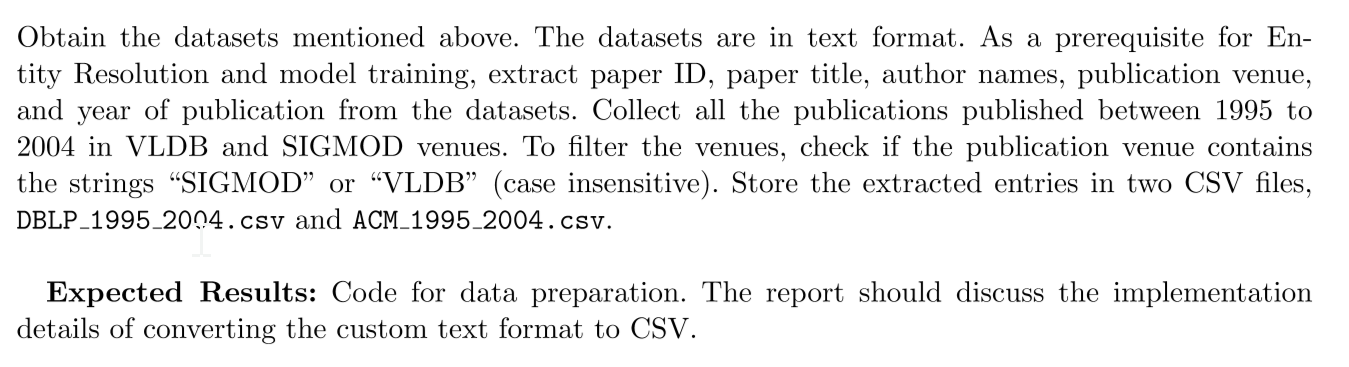

### Load Data

In [ ]:
with open(DLBP_PATH, 'r', encoding='utf-8') as file:
    rows_dblp = file.readlines()
with open(ACM_PATH, 'r', encoding='utf-8') as file:
    rows_acm = file.readlines()

View example rows

In [ ]:
#rows_dblp[0:20]

In [ ]:
#rows_acm[0:20]

### Parser

https://www.aminer.org/citation

In [ ]:
dblp_df = parse_text(rows_dblp)
#dblp_df.head()

In [ ]:
acm_df= parse_text(rows_acm)
acm_df.head()

Check types

In [ ]:
dblp_df.dtypes

In [ ]:
acm_df.dtypes

### 1995 - 2004 & SIGMOD, VLDB

In [ ]:
filtered_dblp_df = dblp_df[(dblp_df['Year'] >= 1995) & (dblp_df['Year'] <= 2004) & dblp_df['Venue'].str.contains('sigmod|vldb', case=False)]
#filtered_dblp_df.head()

In [ ]:
filtered_acm_df = acm_df[(acm_df['Year'] >= 1995) & (acm_df['Year'] <= 2004) & acm_df['Venue'].str.contains('sigmod|vldb', case=False)]
#filtered_acm_df.head()

### Missing values

In [ ]:
filtered_acm_df.isnull().sum()

In [ ]:
filtered_dblp_df.isnull().sum()

In [ ]:
missing_author_acm = filtered_acm_df[filtered_acm_df.isnull().any(axis=1)]
#missing_author_acm.head()

In [ ]:
missing_author_dblp = filtered_dblp_df[filtered_dblp_df.isnull().any(axis=1)]
#missing_author_dblp.head()

#### Filter NA rows out

In [ ]:
filtered_dblp_df = filtered_dblp_df.dropna()
filtered_acm_df = filtered_acm_df.dropna()

### CSV

In [ ]:
filtered_dblp_df.to_csv(OUT_DBLP_FILTERED, index=False)
filtered_acm_df.to_csv(OUT_ACM_FILTERED, index=False)

## 2) Entity Resolution Pipeline

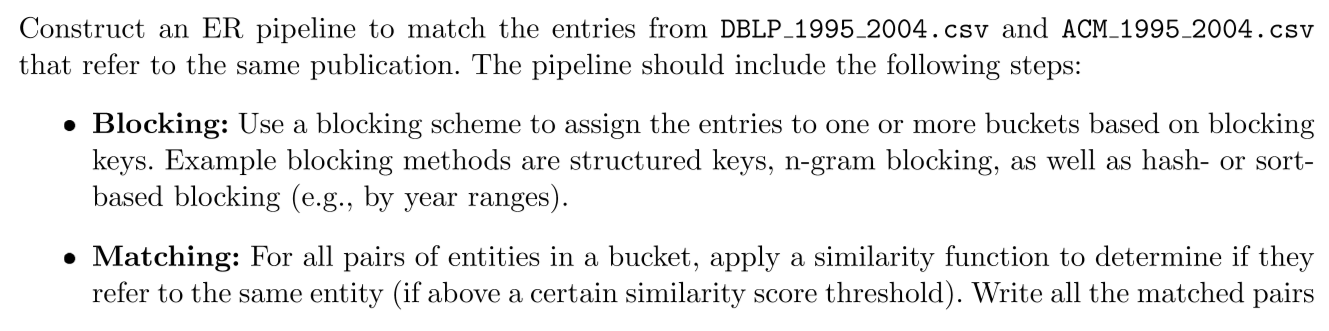
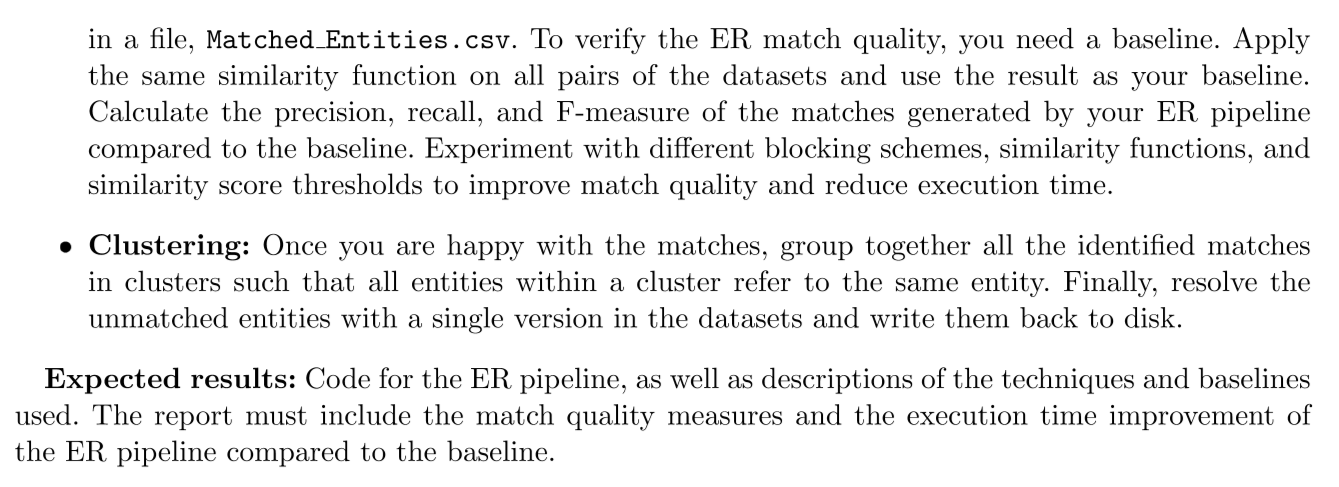

Load CSV from File

In [3]:
filtered_dblp_df = cast_df(pd.read_csv(OUT_DBLP_FILTERED))
filtered_acm_df = cast_df(pd.read_csv(OUT_ACM_FILTERED))

Check if datatypes are correct

In [4]:
filtered_acm_df.dtypes

Title      string[python]
Authors    string[python]
Year                Int64
Venue      string[python]
Index      string[python]
dtype: object

### Blocking

Dataset size

In [5]:
print(filtered_dblp_df.shape[0])
print(filtered_acm_df.shape[0])

2130
2846


#### Strategy 1: Extract first character of first word and first character of last word in Authors

Example

In [6]:
buckets_by_author("moritz wassmer, frederick a. meier")

'm, w'

Create new column for bucket

Blocking scheme reduced number of replaced number of rows by 50% less partitions by 50% 

In [7]:
filtered_acm_df["bucket"] =  filtered_acm_df["Authors"].apply(buckets_by_author)
filtered_dblp_df["bucket"] =  filtered_dblp_df["Authors"].apply(buckets_by_author)
print(len(set(filtered_acm_df["bucket"])))
print(len(set(filtered_dblp_df["bucket"])))

1291
988


More in depth look into bucket size distribution

In [8]:
#pip install seaborn

In [9]:
quantiles = [0.5, 0.75, 0.95, 0.99]


viz_data_dblp = filtered_dblp_df.groupby("bucket").size().reset_index(name='count').sort_values("count", ascending = False)
quantile_values = viz_data_dblp['count'].quantile(quantiles)
viz_data_acm = filtered_acm_df.groupby("bucket").size().reset_index(name='count').sort_values("count", ascending = False)
quantile_values2 = viz_data_acm['count'].quantile(quantiles)

print(quantile_values)
print(quantile_values2)

0.50     1.00
0.75     2.00
0.95     5.00
0.99    24.26
Name: count, dtype: float64
0.50     1.0
0.75     2.0
0.95     7.0
0.99    22.2
Name: count, dtype: float64


unique_buckets

In [10]:
unique_buckets = set(filtered_acm_df["bucket"]).union(set(filtered_dblp_df["bucket"]))
len(unique_buckets)

1424

### Matching

#### Run Experiments

Subset of rows for faster runtime

In [11]:
sub_acm = filtered_acm_df[0:500]
sub_dblp = filtered_dblp_df[0:500]

Run Matching

In [12]:
bucket_matched, bucket_unmatched = match_by_bucket(sub_acm, sub_dblp, similarity_function=total_similarity, threshold = 0.9)
print(len(bucket_matched))
print(bucket_matched[0])

100%|██████████| 564/564 [00:02<00:00, 222.06it/s]

24
('5390975920f70186a0dfe2b8', '53e9afb3b7602d9703a008d3')


Run Matching for Baseline

In [13]:
unbucket_matched, unbucket_unmatched = match_without_bucket(sub_acm, sub_dblp, similarity_function=total_similarity, threshold = 0.9)
print(len(unbucket_matched))
print(unbucket_matched[0])

100%|██████████| 250000/250000 [01:05<00:00, 3820.88it/s]

25
('5390975920f70186a0dfe2ac', '53e9b33eb7602d9703e145a9')


Create dataframe and save mached ids to CSV

In [14]:
bucketized_results_df = pd.DataFrame(bucket_matched, columns =['ACM', 'DBLP'])
bucketized_results_df.to_csv(OUT_MATCHED, index=False)

unbucketized_results_df = pd.DataFrame(unbucket_matched, columns =['ACM', 'DBLP'])
unbucketized_results_df.to_csv(OUT_MATCHED_BASELINE, index=False)

#### Evaluation

##### Intuition

In [15]:
#truth = [(a,b) (b,c) (d,e)]
#preds = [(a,b) (b,f) ]

#TP = (a,b) |truth.intersect(preds)|
#FP = (b,f) |preds.without(truth)|
#FN = (d,e), (b,c) |truth.without(preds)|
#TN = (x,y) |iterations of match_wo_bucket or acm.nrows() * dblp.nrows()|

# Define the truth and predictions sets
truth = {('a', 'b'), ('b', 'c'), ('d', 'e')}
preds = {('a', 'b'), ('b', 'f')}

# Calculate True Positives (TP)
tp = truth.intersection(preds)

# Calculate False Positives (FP)
fp = preds - truth

# Calculate False Negatives (FN)
fn = truth - preds

# Display the results
print("True Positives (TP):", tp)
print("False Positives (FP):", fp)
print("False Negatives (FN):", fn)


True Positives (TP): {('a', 'b')}
False Positives (FP): {('b', 'f')}
False Negatives (FN): {('b', 'c'), ('d', 'e')}


##### Our case

In [16]:
evaluate(set(unbucket_matched), set(bucket_matched), set(bucket_unmatched))

True Positives (TP): 24
False Positives (FP): 0
False Negatives (FN): 1
True Negatives (TN): 754
Precision: 1.0
Recall: 0.96
F1-score: 0.9795918367346939


### Clustering

In my clustering scheme i simply keep the ACM records.

In [18]:
def find_connected_components(edges):
    graph = {}
    
    # Create an adjacency list
    for edge in edges:
        for node in edge:
            if node not in graph:
                graph[node] = set()
    
    for edge in edges:
        graph[edge[0]].add(edge[1])
        graph[edge[1]].add(edge[0])  # If the graph is undirected, include this line

    visited = set()
    connected_components = []

    def dfs(node, component):
        visited.add(node)
        component.add(node)
        for neighbor in graph[node]:
            if neighbor not in visited:
                dfs(neighbor, component)

    for node in graph:
        if node not in visited:
            component = set()
            dfs(node, component)
            connected_components.append(component)

    return connected_components

# Given list of edges
edges = bucket_matched

# Find connected components
components = find_connected_components(edges)

# Print the connected components
for component in components:
    print(f"Connected component: {component}")

Connected component: {'5390975920f70186a0dfe2b8', '53e9afb3b7602d9703a008d3'}
Connected component: {'53e9a6bcb7602d9702ff26e4', '5390979920f70186a0dffb83'}
Connected component: {'53e9a55cb7602d9702e84b64', '5390979920f70186a0dffb84'}
Connected component: {'53e9a627b7602d9702f57d83', '5390979920f70186a0dffb8f'}
Connected component: {'5390975920f70186a0dfe2b0', '53e99938b7602d9702179229'}
Connected component: {'53e9af46b7602d9703986ab6', '5390975920f70186a0dfe2af'}
Connected component: {'5390979920f70186a0dffb8c', '53e99a49b7602d97022acf07'}
Connected component: {'53e9a635b7602d9702f636c2', '5390979920f70186a0dffb86'}
Connected component: {'5390975920f70186a0dfe2c0', '53e9bcd2b7602d9704956f2b'}
Connected component: {'53e9aabdb7602d970343b0bc', '5390975920f70186a0dfe2b6'}
Connected component: {'53e9bdacb7602d9704a5afe4', '5390975920f70186a0dfe2ad'}
Connected component: {'5390980720f70186a0e01e36', '53e99a67b7602d97022d556a'}
Connected component: {'53e9b98ab7602d970457d0e7', '5390980720f70

# 3) Data-Parallel Entity Resolution Pipeline

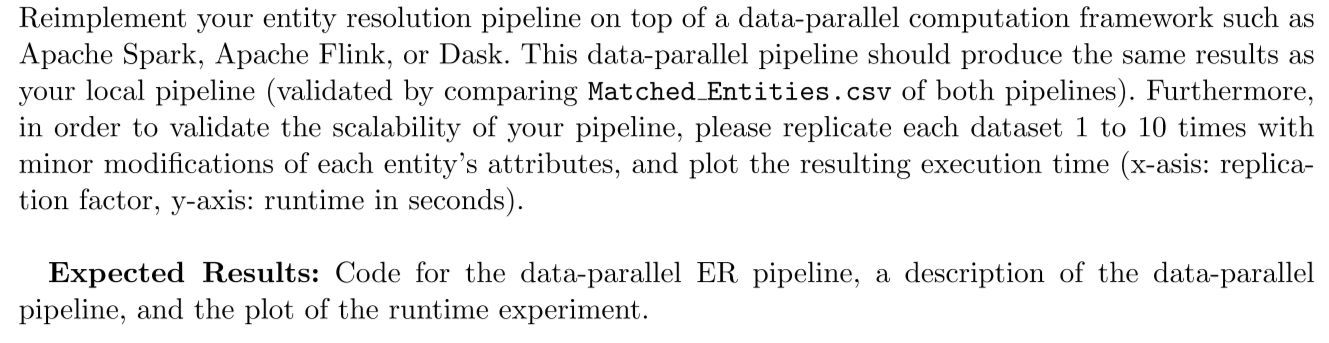